In [1]:
%matplotlib inline

In [2]:
import os
import glob
import re
import pandas as pd
import numpy as np

In [3]:
def load_data(dataset):
    df = pd.read_csv(f'results/r_{dataset}.csv', index_col=0)
    return df

In [4]:
def get_newest_files():
    files = glob.glob('results/*.csv')
    files.sort(key=os.path.getctime, reverse=True)
    files = map(lambda x: os.path.basename(x), files)
    files = map(lambda x: os.path.basename(x), files)
    files = map(lambda x: os.path.splitext(x)[0], files)
    files = map(lambda x: re.match(r'^r_(?P<id>.*)', x).group('id'), files)
    return list(files)

In [5]:
#get_newest_files()

- proportion wearing masks 0.5 (0.1, 0.95)
- test start proportion 0.05 (0.01, 0.1)
- self isolate proportion 0.7 (0.1, 0.95)
- test chances 0.005, 0.01, 0.3, 0.8 (0.001, 0.01)
- healthcare capacity (ewentualnie) 100 (50, 150)
- speed 0.01 (0.005, 0.04)

- severity2 count
- dead count
- unaffected count
- 75% discover rate (min 25%)

## Added features

### Symptoms severity

We introduced three levels of severity:
- asymptomatic (0)
- mild (1)
- severe (2)

They work and alter the simulation in the following ways:
- agents get assigned their target severity level upon infection
- target severity is sampled from a distribution chosen based on agent's age
- agents ilnesses progress according to a schedule defined by a parameter *'infection_progression_duration'*
    - default value = \[20, 70, 140\]
    - it means that the agent may become asymptomatic after 20 ticks (2 days), mild after 70 ticks (7 days) and severe after 140 ticks (14 days)
    - note here that the agent recovers according to *'recovery_duration'* (200 - 500 ticks)
    - '10 ticks = 1 day' has been deduced based on this parameter
    - severity will not progress further than agent's target severity
- severity influences influences the following:
    - probability of self-isolation based on symptoms
    - priority of getting a test
    - likelihood of infecting others (infection chance is multiplied by 0.5, 1 and 2 respectively for increasing levels of severity)
    - agent may die only at severity = 2


### Custom age distribution

Age distribution is defined with probabilities for each 10-year period between 0 and 90 years of age.

### Correlating parameters with age

The following have been correleted with age:
- symptoms severity
- speed

### Wearing masks

Proportion of agents wearing masks can be controlled with *'proportion_wearing_masks'* parameter (0.5 by default).
When two agents are in close proximity the formula for computing the infection chance is:
- *infection_chance_1 \* infection_chance_2 \* severity_infection_chance_multiplier*
- *infection_chance_n* becomes *infection_chance_with_mask* if agent n is wearing a mask (so the infection chance decreases greatly if both agent are wearing masks)  

### Testing

We came up with the following strategy of testing:
- testing is performed every day (every 10 ticks)
- it starts when at least *'test_proportion_to_start'* (5%) of population is sick (the time at which the epidemic is noticed)
- the possible number of tests each day is limited by *'min_tests_daily_proportion'* and *'max_tests_daily_proportion'* (fraction of population, e.g. 0.5% and 5% for 2000 agents will be between 10 and 100 tests daily)
- the actual number of tests for the day is computed as *(1 / 'desired_positive_proportion' \* 'pop_size')* and then limited with min and max
- *'desired_positive_proportion'* controls the number of tests by the desired fraction of positive results (this value should be low to reliably keep track of the epidemic)
- tests are first allocated to untested severe cases
- the reminder goes to untested mild cases
- finally the rest of the daily test pool goes to untested asymptomatic cases and healthy agents (without discriminating, because these cases would be indistinguishable inreality)
- being tested positively maximizes the chances of agent's isolation

### Self-isolating

Probability of self-isolating has been defined with the following formula:
- max(1, tested + self_isolate_severity_proportion\[severity\]) \* self_isolate_proportion
- self_isolate_severity_proportion = \[0.0, 0.2, 0.7\]
- self_isolate_proportion = 0.7

### Other
We changed the start of the epidemic from one agent to 5 agents to make the results more repeatable (with one agent the epidemic would often not develop)

In [6]:
import matplotlib.pyplot as plt

def plot_full_results(id, plot_sir=True, plot_severity=True, plot_test_cnt=True, plot_test_percentage=True, figsize=(8,6)):
    df = load_data(id)
    display(df.tail(1)[['susceptible', 'recovered', 'fatalities', 'severity0', 'severity1', 'severity2']])

    if plot_sir:
        ax = df[['infected', 'infected_known']].plot(figsize=figsize, lw=3)
        df[['susceptible', 'recovered', 'fatalities']].plot(ax = ax, style='--')
    
    if plot_severity:
        ax = df[['infected', 'infected_known']].plot(figsize=figsize, lw=3)
        df[['severity0', 'severity1', 'severity2', 'fatalities']].plot(ax = ax, style='--')
    
    if plot_test_cnt:
        plt.figure()
        daily_new_cases = -df.iloc[::10].susceptible.diff()
        ax = daily_new_cases.plot(figsize=figsize, style='--')
        df[['positive', 'number_of_tests']].dropna().plot(ax = ax)
        plt.legend(['daily_new_cases', 'positive_tests', 'number_of_tests'])
    
    if plot_test_percentage:
        df.dropna(inplace = True)
        df['%_detected'] = df.infected_known/df.infected
        df['%_positive_tests'] = (df.positive/df.number_of_tests)
        df['%_infected'] = (df.infected/2000)
        ax = df[['%_infected']].plot(figsize=figsize, style='--')
        df[['%_positive_tests', '%_detected']].plot(ax = ax)



## How did we come up with a working testing solution?

- daily test capacity: 0.005 - 0.05 of population
- number of tests based on positive tests from the **last day**
- isolation based only on test results

,susceptible,recovered,fatalities,severity0,severity1,severity2
696,0,1878,122,631,899,467


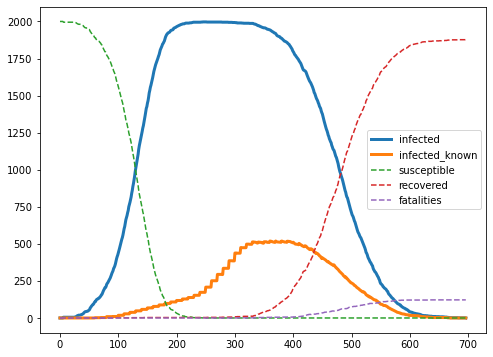

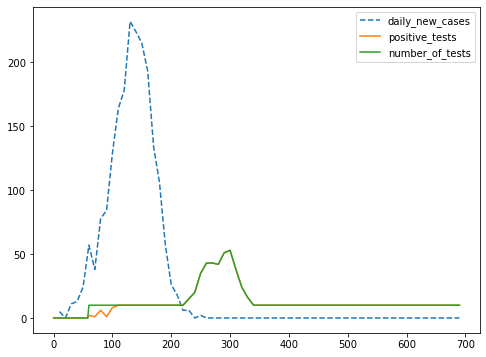

In [7]:
plot_full_results('1613837416', plot_severity=False, plot_test_percentage=False)

In [8]:
#plot_full_results('1613837825', plot_severity=False, plot_test_percentage=False)

In [9]:
#plot_full_results('1613837912', plot_severity=False, plot_test_percentage=False)

In [10]:
#plot_full_results('1613838008', plot_severity=False, plot_test_percentage=False)

- daily test capacity: 0.005 - 0.05 of population
- number of tests based on positive tests from the **last 3 days (rolling average)**
- isolation based only on test results

,susceptible,recovered,fatalities,severity0,severity1,severity2
694,0,1845,155,629,988,379


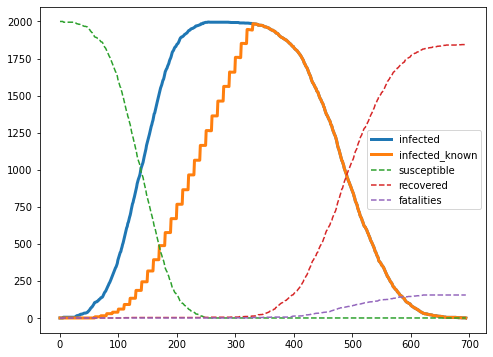

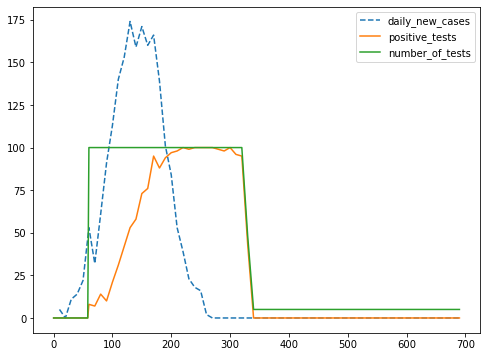

In [11]:
plot_full_results('1613838353', plot_severity=False, plot_test_percentage=False)

In [12]:
#plot_full_results('1613838431', plot_severity=False, plot_test_percentage=False)

In [13]:
#plot_full_results('1613838639', plot_severity=False, plot_test_percentage=False)

In [14]:
#plot_full_results('1613840355', plot_severity=False, plot_test_percentage=False)

- daily test capacity: **0.0 - 0.5** of population
- number of tests based on positive tests from last 3 days (rolling average)
- **trying to keep positive tests proportion at 10%**
- isolation based only on test results

,susceptible,recovered,fatalities,severity0,severity1,severity2
761,0,1831,169,629,951,415


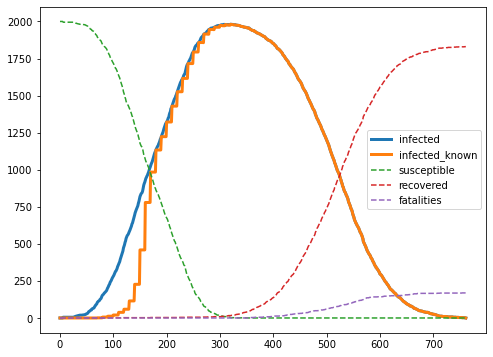

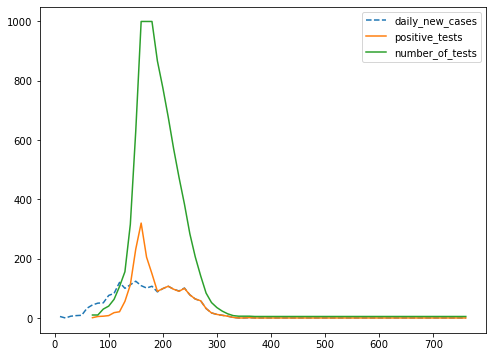

In [15]:
plot_full_results('1613840532', plot_severity=False, plot_test_percentage=False)

In [16]:
#plot_full_results('1613840819', plot_severity=False, plot_test_percentage=False)

In [17]:
#plot_full_results('1613841169', plot_severity=False, plot_test_percentage=False)

- daily test capacity: **0.005 - 0.05** of population
- number of tests based on positive tests from last 3 days (rolling average)
- trying to keep positive tests proportion at 10%
- isolation based on test results **and symptoms**

,susceptible,recovered,fatalities,severity0,severity1,severity2
1064,1608,389,3,135,172,84


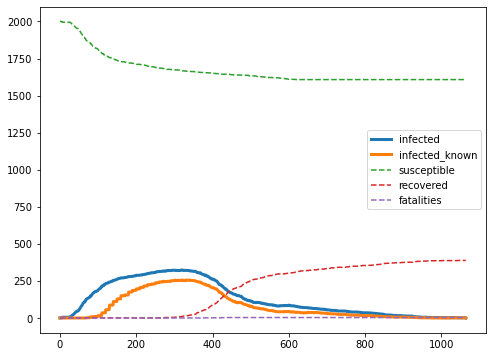

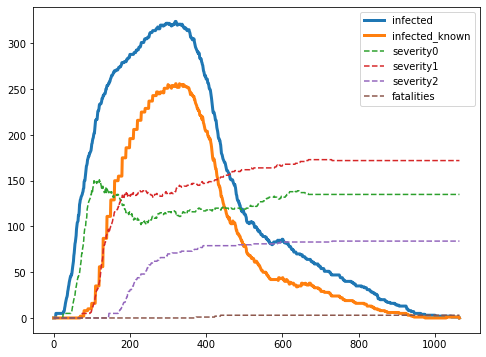

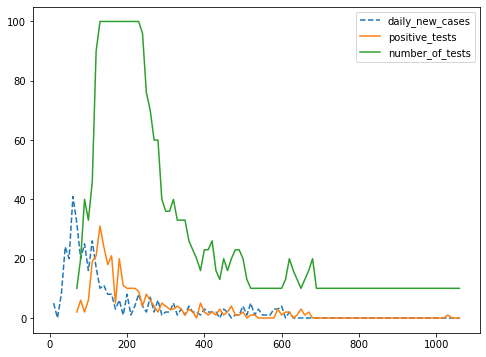

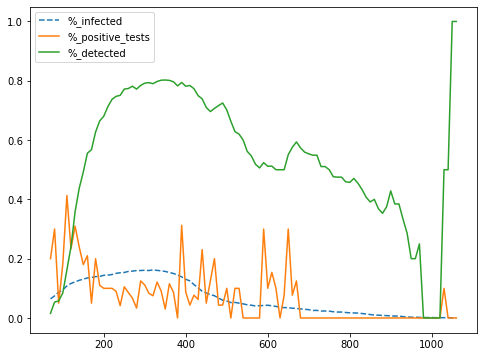

In [18]:
plot_full_results('1613841500')

## Desired % of positive tests
How does it affect % of detected cases?

,susceptible,recovered,fatalities,severity0,severity1,severity2
952,1381,611,8,191,305,123


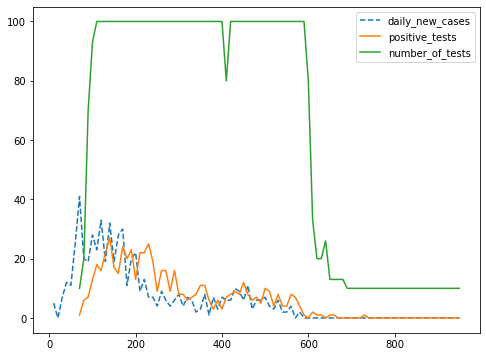

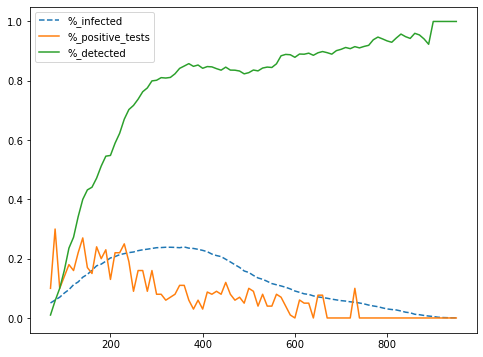

In [19]:
# aiming at 5%
plot_full_results('1613917650', plot_sir=False, plot_severity=False)

,susceptible,recovered,fatalities,severity0,severity1,severity2
1546,1152,821,27,270,408,168


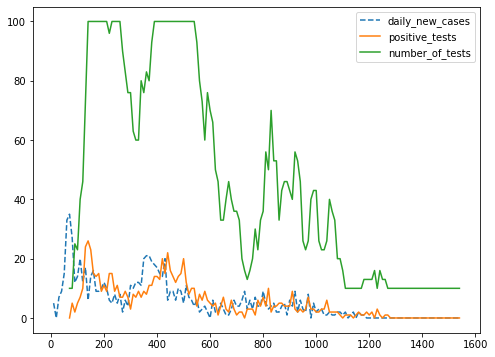

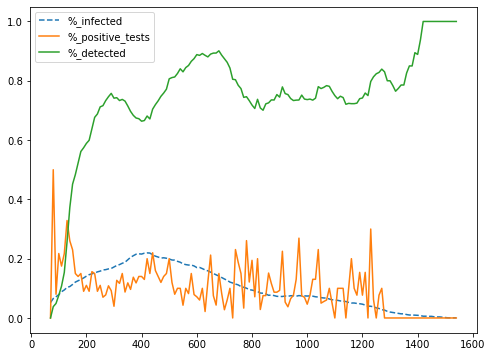

In [20]:
# aiming at 10%
plot_full_results('1613916584', plot_sir=False, plot_severity=False)

,susceptible,recovered,fatalities,severity0,severity1,severity2
1267,1286,702,12,217,362,133


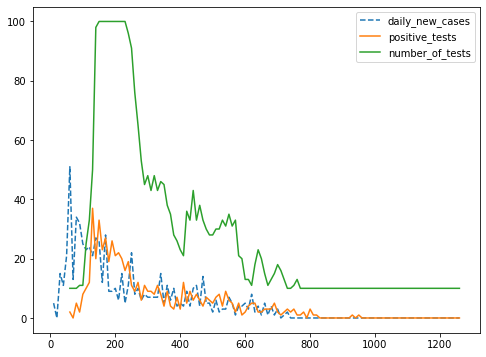

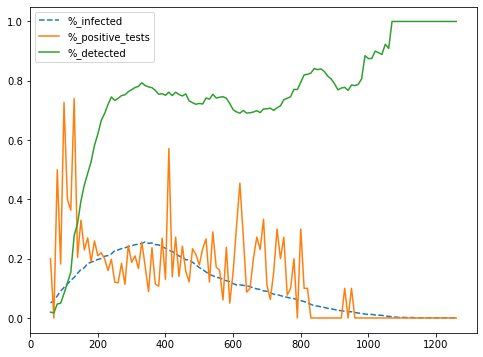

In [21]:
# aiming at 20%
plot_full_results('1613916811', plot_sir=False, plot_severity=False)

,susceptible,recovered,fatalities,severity0,severity1,severity2
814,1505,489,6,154,242,96


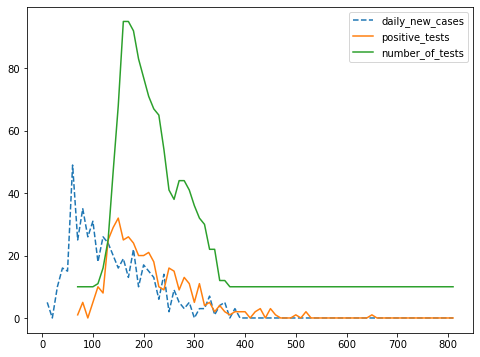

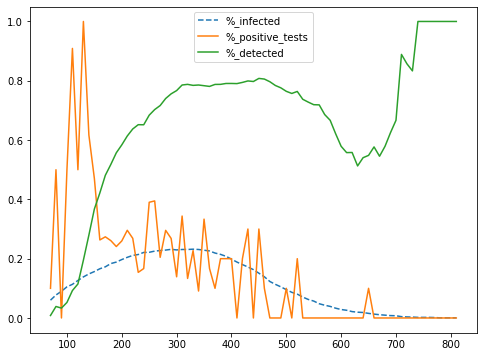

In [22]:
# aiming at 30%
plot_full_results('1613917215', plot_sir=False, plot_severity=False)

,susceptible,recovered,fatalities,severity0,severity1,severity2
847,1289,690,21,238,317,155


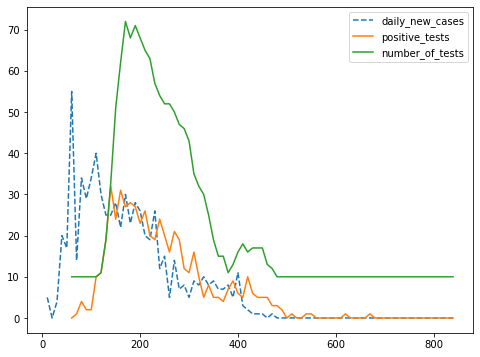

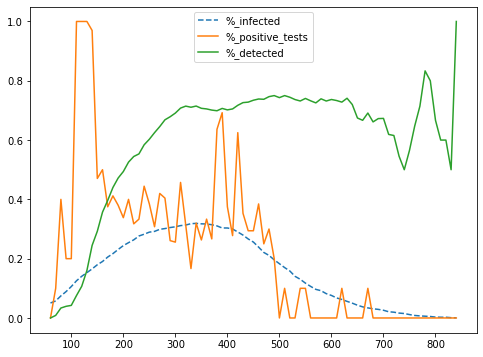

In [23]:
# aiming at 40%
plot_full_results('1613917485', plot_sir=False, plot_severity=False)

## Max number of tests
How does it affect % of detected cases and total number of cases?

,susceptible,recovered,fatalities,severity0,severity1,severity2
964,1511,483,6,154,235,100


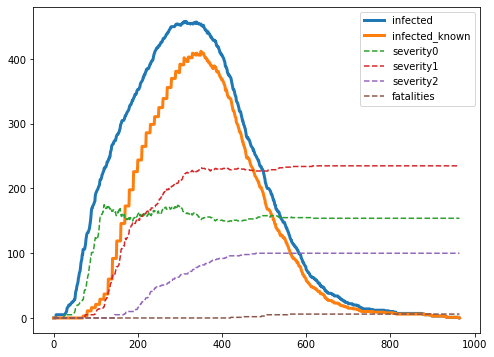

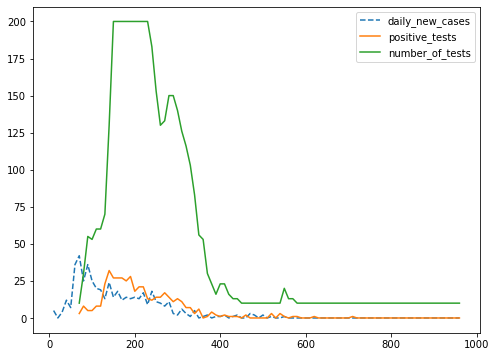

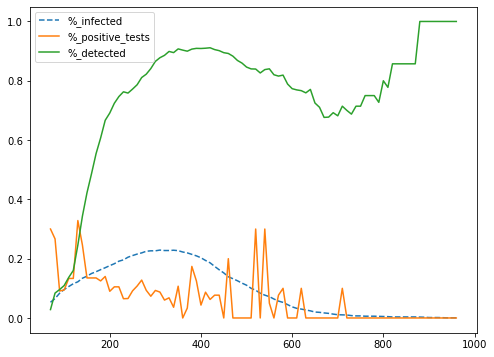

In [24]:
# max tests daily = 10% of population
plot_full_results('1613918582', plot_sir = False)

,susceptible,recovered,fatalities,severity0,severity1,severity2
797,1401,591,8,197,284,117


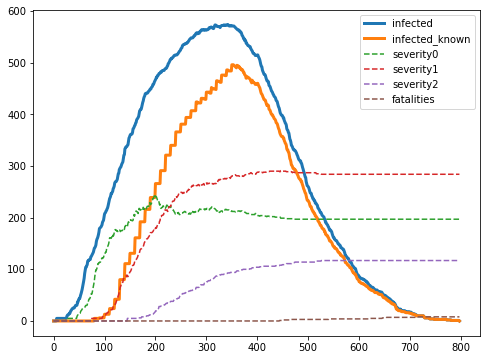

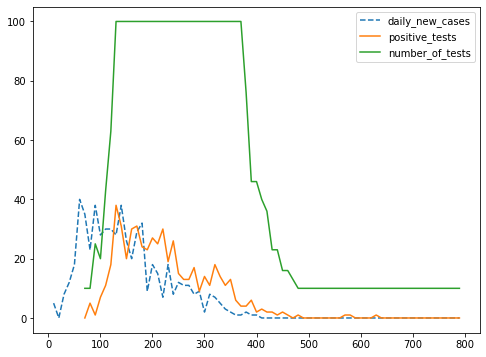

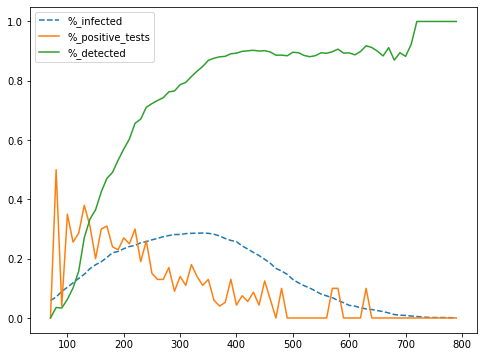

In [25]:
# max tests daily = 5% of population
plot_full_results('1613918677', plot_sir = False)

,susceptible,recovered,fatalities,severity0,severity1,severity2
990,1403,588,9,199,287,111


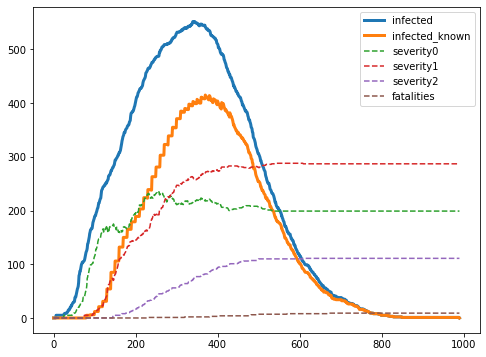

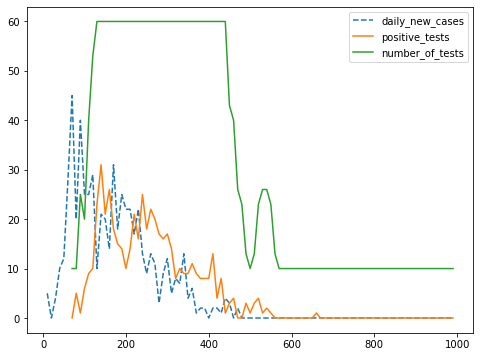

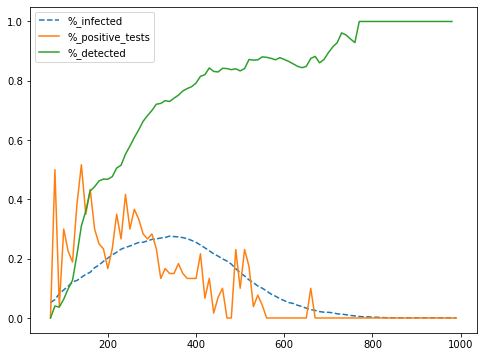

In [26]:
# max tests daily = 3% of population
plot_full_results('1613918800', plot_sir = False)

## Wearing masks

How does it affect the total number of cases?

,susceptible,recovered,fatalities,severity0,severity1,severity2
563,1855,143,2,40,72,33


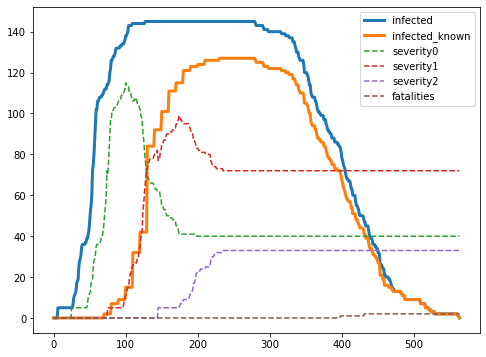

In [27]:
# 90% masks
plot_full_results('1613917862', plot_sir = False, plot_test_cnt=False, plot_test_percentage=False)

,susceptible,recovered,fatalities,severity0,severity1,severity2
607,1838,162,0,48,79,35


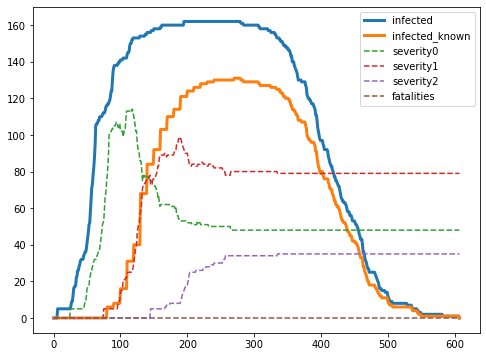

In [28]:
# 80% masks
plot_full_results('1613918068', plot_sir = False, plot_test_cnt=False, plot_test_percentage=False)

,susceptible,recovered,fatalities,severity0,severity1,severity2
659,1791,207,2,67,103,39


,susceptible,recovered,fatalities,severity0,severity1,severity2
741,1603,391,6,119,174,102


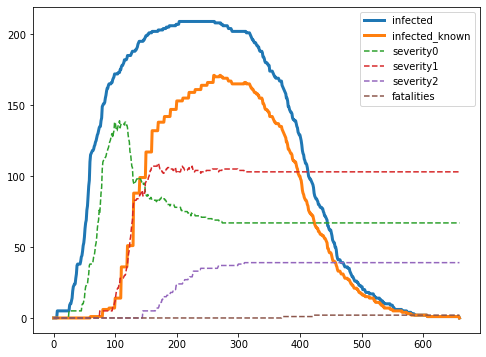

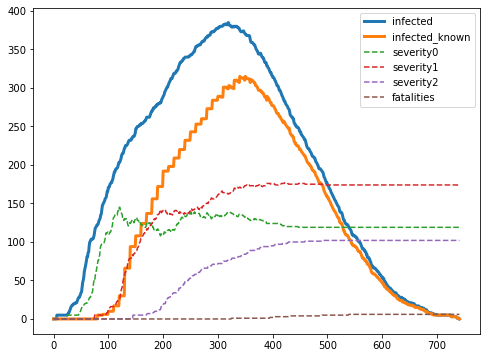

In [29]:
# 60% masks
plot_full_results('1613918153', plot_sir = False, plot_test_cnt=False, plot_test_percentage=False)
plot_full_results('1613918404', plot_sir = False, plot_test_cnt=False, plot_test_percentage=False)

,susceptible,recovered,fatalities,severity0,severity1,severity2
944,1342,652,6,219,323,116


,susceptible,recovered,fatalities,severity0,severity1,severity2
1079,1101,884,15,280,441,177


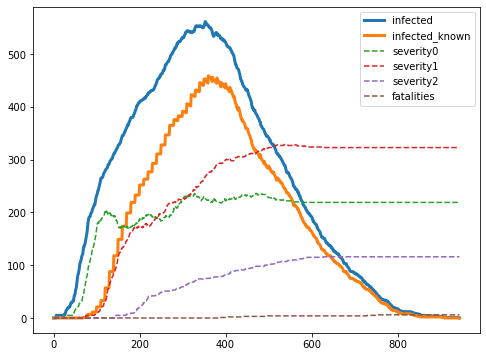

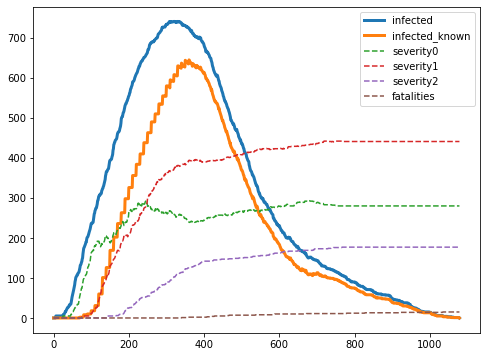

In [30]:
# 50% masks
plot_full_results('1613918271', plot_sir = False, plot_test_cnt=False, plot_test_percentage=False)
plot_full_results('1613918337', plot_sir = False, plot_test_cnt=False, plot_test_percentage=False)